# Program for Data Preparation, RandomForest Variable Importance, GBM Hyper-Parameter Tuning, Naive Bayes, Logistic Regression, Stack Models and Gain Chart

## Table of Contents

* [Data Preparation](#DataPreparation)
    * [Data Cleaning and Missing Imputation](#impute)
    * [Create binning variable and weight of evidence (WOE)](#woe)
    * [Correlation Heatmap and Bar Chart](#corr)
    * [Create dummy variable for bins](#dummy)
    * [RandomForest Variable Importance](#rf_imp)

* [Model 1: GBM for Classification](#Model1)
    * [Tune hyper-parameter](#tune)
    * [CV to find optimal hyper-parameter](#tune_run)
* [Model 2: Stack Models of GBM, Naive Bayes and Logistic Regression](#Model2)
    * [Logistic Regression and Naive Bayes Model](#logit)
    * [Gain Chart Plot](#gain_chart)
    * [AUC from Cross-Validation](#cv)
    * [Stack Models](#stack)

## Load Python libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import glob
import pickle
import gc
import os

In [2]:
# to display max rows and columns when print 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/root/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


## Data Preparation <a class="anchor" id="DataPreparation"></a>

In [3]:
df_train1=pd.read_csv('/disk/exercise/exercise_02_train_1.csv') # read separately due to file size limit from email
df_train2=pd.read_csv('/disk/exercise/exercise_02_train_2.csv') 
df_test=pd.read_csv('/disk/exercise/exercise_02_test.csv') 

In [4]:
df_train=df_train1.append(df_train2, ignore_index = True) # append two files
df_train.to_csv('/disk/exercise/df_train.csv',index=False)

### Data Cleaning and Missing Value Imputation <a class="anchor" id="impute"></a>

#### Convert $ value of x41 to numeric and set x45 to categorical due to fewer limited different values

In [5]:
df_train['x41_float'] = df_train['x41'].apply(lambda x: x.replace('$', '').replace(',', '')
                                if isinstance(x, str) else x).astype(float)

df_train['x45_cat']=df_train['x45'].astype(str)
                                        

df_test['x41_float'] = df_test['x41'].apply(lambda x: x.replace('$', '').replace(',', '')
                                if isinstance(x, str) else x).astype(float)

df_test['x45_cat']=df_test['x45'].astype(str)
                                          

df_train.drop(['x41','x45'],axis=1,inplace=True)
df_test.drop(['x41','x45'],axis=1,inplace=True)


### Check missing values: Missing value is less than 0.5%, impute numeric missing fields by column mean


In [266]:
# check variable type
#df_train.dtypes

In [ ]:
# check missing value
df_train.isnull().sum()
df_test.isnull().sum()

In [6]:
#impute missing numeric field by column mean
df_train=df_train.fillna(df_train.mean())
df_test=df_test.fillna(df_test.mean())

In [ ]:
# check values of categorical(string) values and combine same values such as 'friday' and 'fri'
c_lst=['x34','x35','x45_cat','x68','x93']
for c in c_lst:
    print(df_train[c].value_counts())
    
for c in c_lst:
    print(df_test[c].value_counts())

In [7]:
# clean up categorical variable values and impute missing with mode

df_train['x35']=df_train['x35'].apply(lambda x: 'friday' if x=='fri' else x)
df_train['x35']=df_train['x35'].apply(lambda x: 'thurday' if x=='thur' else x)
df_train['x35']=df_train['x35'].apply(lambda x: 'wednesday' if x=='wed' else x)
df_train['x35']=df_train['x35'].apply(lambda x: 'wednesday' if x=='wendesday' else x)
df_train['x35']=df_train['x35'].fillna('nan')
df_train['x35']=df_train['x35'].apply(lambda x: 'wednesday' if x=="nan" else x)
df_train['x45_cat']=df_train['x45_cat'].apply(lambda x: '0.01%' if x=='nan' else x)
df_train['x34']=df_train['x34'].fillna('nan')
df_train['x34']=df_train['x34'].apply(lambda x: 'volkswagon' if x=="nan" else x)
df_train['x68']=df_train['x68'].fillna('nan')
df_train['x68']=df_train['x68'].apply(lambda x: 'July' if x=="nan" else x)
df_train['x93']=df_train['x93'].fillna('nan')
df_train['x93']=df_train['x93'].apply(lambda x: 'asia' if x=="nan" else x)

df_test['x35']=df_test['x35'].apply(lambda x: 'friday' if x=='fri' else x)
df_test['x35']=df_test['x35'].apply(lambda x: 'thurday' if x=='thur' else x)
df_test['x35']=df_test['x35'].apply(lambda x: 'wednesday' if x=='wed' else x)
df_test['x35']=df_test['x35'].fillna('nan')
df_test['x35']=df_test['x35'].apply(lambda x: 'wendesday' if x=="nan" else x)
df_test['x45_cat']=df_test['x45_cat'].apply(lambda x: '0.01%' if x=='nan' else x)
df_test['x34']=df_test['x34'].fillna('nan')
df_test['x34']=df_test['x34'].apply(lambda x: 'volkswagon' if x=="nan" else x)
df_test['x68']=df_test['x68'].fillna('nan')
df_test['x68']=df_test['x68'].apply(lambda x: 'July' if x=="nan" else x)
df_test['x93']=df_test['x93'].fillna('nan')
df_test['x93']=df_test['x93'].apply(lambda x: 'asia' if x=="nan" else x)

In [8]:
# Save a copy of data
df_train.to_csv('/disk/exercise/df_train_clean.csv',index=False)
df_test.to_csv('/disk/exercise/df_test_clean.csv',index=False)

<a class="anchor" id="woe"></a>
## Derive new variables: Binning variables based on weight of evidence (WOE) and information value (IV). Bins and WOE of X can pick up non-linear relationships with the target  y 

In [9]:
#pip install xverse
from xverse.transformer import MonotonicBinning
from xverse.transformer import WOE

In [10]:
# create feature data X and target y 
X=df_train.drop('y',axis=1)
y=df_train['y']

In [11]:
# create monotonic binning based on %target in the bins
clf_bin = MonotonicBinning()
clf_bin.fit(X, y)
output_bins = clf_bin.bins

In [12]:
# convert X variable values into bins
clf_bin=MonotonicBinning(custom_binning=output_bins)
out_bin_X=clf_bin.transform(X)

In [13]:
out_bin_X.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x42,x43,x44,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x41_float,x45_cat
0,"(-3.498, 10.388]","(8.023, 153.469]","(18.18, 154.051]","(-6.2780000000000005, -0.712]","(-6.877, 7.114]","(6.133, 63.424]","(-3.849, 3.885]","(-26.738, -3.048]","(-53.736999999999995, -8.545]","(-11.498, -1.305]","(-9.701, 25.072]","(-17.848000000000003, -1.892]","(-12.084, 3.23]","(1.088, 10.468]","(1.329, 12.778]","(-35.47, -3.708]","(-1.791, 1.727]","(-2.879, 2.815]","(-103.96000000000001, -5.162]","(-9.118, 9.115]","(-72.674, -3.888]","(-8.663, 21.704]","(13.729, 161.447]","(-3.263, 3.206]","(-14.716, -1.606]","(1.721, 18.599]","(-0.243, 0.241]","(26.801, 172.001]","(1.229, 13.38]","(-0.367, 0.371]","(-14.376, -1.436]","(-23.832, -2.437]","(-6.761, -0.693]","(-16.232000000000003, -2.175]",Toyota,wednesday,"(0.72, 7.106]","(-127.653, -9.029]","(-30.455000000000002, -3.276]","(4.238, 39.232]","(-13.664, 16.254]","(-109.446, -9.801]","(-6.482, 6.582]","(-423.121, -55.613]","(-34.363, -3.601]","(-1.987, 1.903]","(1.625, 15.231]","(5.627, 55.721]","(12.362, 90.662]","(-167.273, -22.211]","(-0.424, 0.423]","(-10.548, 10.726]","(2.147, 19.731]","(-1.495, 1.569]","(11.683, 132.981]","(14.49, 147.697]","(1.872, 22.421]","(-2.622, 2.593]","(2.407, 22.161]","(6.53, 68.764]","(-30.249000000000002, -3.221]","(3.269, 55.602]","(-3.439, 3.409]","(0.529, 5.449]","(14.303, 204.417]","(-1.642, 1.599]",Jun,"(-35.821, 20.878]","(23.151, 159.477]","(-14.577, 15.902]","(1.855, 32.581]","(-121.801, -16.448]","(-11.564, 11.783]","(20.685, 144.548]","(-2.374, 2.392]","(-159.804, -15.476]","(0.982, 16.759]","(-8.337, 10.721]","(-77.052, -8.357]","(4.229, 43.666]","(2.346, 22.849]","(-1.916, 2.343]","(-2.244, 2.27]","(-11.543, 4.152]","(-0.25, 0.251]","(3.573, 33.242]","(-1.644, 1.644]","(-15.876, -1.742]","(-422.71299999999997, -49.648]","(-1.139, 1.122]","(-1.993, 1.971]",asia,"(-9.397, -0.956]","(11.926, 112.391]","(9.586, 92.927]","(-10.571, 5.418]","(3.657, 34.17]","(0.527, 4.49]","(432.19, 4062.63]",0.0%
1,"(-60.114999999999995, -3.498]","(8.023, 153.469]","(-163.341, -14.617]","(0.571, 5.838]","(-6.877, 7.114]","(-7.34, 6.133]","(3.885, 45.054]","(2.946, 34.268]","(-8.545, 2.729]","(1.225, 11.272]","(-170.57, -9.701]","(1.93, 17.034]","(3.23, 70.297]","(1.088, 10.468]","(1.329, 12.778]","(-3.708, 3.794]","(1.727, 14.829]","(-25.739, -2.879]","(18.721, 107.938]","(9.115, 82.897]","(-3.888, 10.083]","(-145.362, -8.663]","(13.729, 161.447]","(3.206, 29.497]","(-1.606, 1.638]","(1.721, 18.599]","(-0.243, 0.241]","(-143.038, -7.811]","(-11.602, -1.289]","(-3.582, -0.367]","(1.392, 13.026]","(-23.832, -2.437]","(-6.761, -0.693]","(0.804, 14.989]",Honda,wednesday,"(0.72, 7.106]","(18.163, 126.924]","(-30.455000000000002, -3.276]","(4.238, 39.232]","(-13.664, 16.254]","(-109.446, -9.801]","(-6.482, 6.582]","(-423.121, -55.613]","(3.641, 30.857]","(-1.987, 1.903]","(-14.62, -1.553]","(-5.34, 5.627]","(-78.22200000000001, -4.706]","(-22.211, 9.731]","(-3.904, -0.424]","(-90.81200000000001, -10.548]","(-20.398, -2.233]","(-15.929, -1.495]","(-128.053, -14.085]","(14.49, 147.697]","(-3.636, 1.872]","(2.593, 26.398]","(-2.404, 2.407]","(-6.299, 6.53]","(3.161, 27.849]","(-8.682, 3.269]","(3.409, 33.275]","(-0.552, 0.529]","(-177.82500000000002, -19.042]","(-15.699, -1.642]",sept.,"(-35.821, 20.878]","(23.151, 159.477]","(-139.779, -14.577]","(-4.881, 1.855]","(6.912, 92.753]","(-108.745, -11.564]","(-146.96800000000002, -9.417]","(-2.374, 2.392]","(-159.804, -15.476]","(0.982, 16.759]","(-90.339, -8.337]","(-77.052, -8.357]","(-4.309, 4.229]","(-2.251, 2.346]","(-1.916, 2.343]","(-2.244, 2.27]","(4.152, 70.386]","(-2.157, -0.25]","(-3.589, 3.573]","(1.644, 1

In [14]:
# compute WOE for the bins
clf_woe = WOE()
clf_woe.fit(X, y)
##clf.woe_df  # woe table for variables
##clf.iv_df  # IV table

/root/venv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


WOE(mono_custom_binning={'x0': array([-60.1139018 ,  -3.49752736,  10.38794946,  75.31165921]),
                         'x1': array([-157.34111921,  -23.87212124,    8.02334358,  153.46922082]),
                         'x10': array([-170.56928575,   -9.70055411,   25.07155079,  174.68497833]),
                         'x11': array([-17.84668764,  -1.89213528,   1.93028876,  17.03447348]),
                         'x12': array([-78.36557296, -12.0840376 ,   3.23011228,  70.29674968]),
                         'x13':...
                      'chevrolet': -0.9386408054803722,
                      'chrystler': -0.05758687970566121,
                      'ford': 0.09901078339805051,
                      'mercades': -0.38525556729558563,
                      'nissan': -0.01861175149560986,
                      'tesla': -0.054918926369751694,
                      'volkswagon': 0.008262533496907759},
              'x35': {'friday': -0.22636445501143143,
                      'monday': 1

In [15]:
# convert X values into WOE values
out_woe_X=clf_woe.transform(X)

In [16]:
out_woe_X.head()  # show woe table

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x42,x43,x44,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x41_float,x45_cat
0,-0.002129,0.291067,0.215815,0.262730,0.026801,-0.325462,-0.001203,-0.023663,-0.007325,-0.052051,0.022242,-0.000371,0.035883,0.009870,-0.018885,-0.018979,0.004804,0.010330,-0.011045,0.040406,0.223495,-0.044814,-0.276137,-0.01608,-0.010114,0.015838,0.022698,-0.040544,0.002497,-0.011417,0.016660,0.003787,-0.013375,-0.259236,0.008504,0.124870,0.012168,0.472614,0.005632,0.003420,-0.051957,0.039408,-0.003519,-0.292856,0.000091,0.013545,-0.024038,0.005265,-0.286092,-0.378383,-0.011417,0.048518,0.019957,-0.003982,-0.212996,0.061955,0.456666,-0.001203,0.003420,0.037241,-0.001297,0.250779,-0.012349,0.023154,-0.265700,-0.019821,-0.055202,-0.082303,-0.265153,0.048968,0.197680,-0.285627,-0.053390,-0.602437,-0.017950,-0.037796,0.275606,0.008490,-0.043958,-0.010486,-0.015614,0.032710,0.028621,-0.054345,-0.001203,-0.021694,-0.015614,-0.008719,0.012074,0.024979,-0.012815,-0.005078,0.011155,-0.039596,-0.355996,-0.115214,0.044918,0.251584,-0.518762,-0.128360
1,0.163737,0.291067,-0.290628,-0.243964,0.026801,0.087203,0.011249,0.009410,0.072630,0.013545,0.192606,-0.006766,-0.044339,0.009870,-0.018885,0.003420,0.002035,0.014368,0.014921,0.006187,-0.017015,0.262730,-0.276137,0.02589,0.008950,0.015838,0.022698,-0.017576,0.005171,0.034429,-0.019821,0.003787,-0.013375,0.230527,0.003041,0.124870,0.012168,-0.728813,0.005632,0.003420,-0.051957,0.039408,-0.003519,-0.292856,0.014004,0.013545,0.024884,-0.004446,0.245838,0.111663,-0.023663,-0.044908,-0.025540,0.013451,0.262730,0.061955,-0.013281,-0.008625,0.007109,-0.036756,0.009410,-0.035811,0.007569,-0.032035,0.261929,0.026251,0.051342,-0.082303,-0.265153,-0.015707,0.084562,0.236219,-0.017576,0.537204,-0.017950,-0.037796,0.275606,-0.292856,-0.043958,0.008030,0.005265,0.032710,0.028621,0.233782,0.000554,-0.003519,0.016296,0.005265,0.012074,-0.033922,-0.031092,-0.005078,0.011155,-0.039596,0.216127,-0.511671,0.044918,0.251584,0.467883,-0.128360
2,-0.179023,-0.246754,0.215815,0.262730,-0.031563,0.087203,-0.010114,0.009410,-0.007325,-0.052051,0.022242,-0.000371,0.007475,-0.018979,0.005171,0.003420,-0.006860,0.010330,0.014921,0.006187,-0.017015,-0.258601,-0.004446,-0.01608,0.008950,-0.000277,-0.007695,0.056592,-0.007695,-0.023569,0.002958,-0.010486,-0.013375,-0.259236,-0.002216,0.124870,-0.000740,0.472614,0.005632,0.007015,-0.051957,-0.021694,-0.003519,0.195608,0.014004,0.013545,0.024884,-0.004446,-0.001665,0.111663,0.034524,0.048518,-0.025540,0.013451,-0.212996,-0.033543,-0.013281,0.009776,0.003420,-0.036756,-0.008160,0.250779,0.004710,-0.032035,-0.037702,-0.006766,0.340621,0.260426,-0.265153,-0.034394,0.197680,-0.285627,-0.017576,0.537204,0.022603,-0.037796,-0.062971,0.008490,-0.032506,0.008030,0.010236,0.218275,-0.001297,-0.209391,0.000648,-0.003519,0.016296,0.003420,-0.006302,0.024979,-0.012815,0.081786,0.029531,-0.039596,0.216127,0.479982,-0.010020,0.251584,0.467883,-0.197016
3,0.163737,0.291067,0.215815,-0.243964,-0.031563,0.087203,0.011249,0.009410,-0.068264,-0.052051,-0.243425,-0.006766,-0.044339,0.009870,-0.018885,-0.018979,0.002035,-0.024977,0.014921,-0.047761,-0.238042,-0.258601,-0.004446,0.02589,0.001110,-0.015707,-0.007695,0.056592,0.005171,0.034429,0.016660,-0.010486,-0.013375,-0.006766,0.008263,0.124870,-0.000740,-0.728813,0.055697,0.003420,-0.246214,-0.018417,-0.003519,0.059722,0.014004,-0.012909,0.024884,-0.000834,-0.286092,0.111663,-0.023663,-0.044908,-0.025540,-0.003982,-0.212996,0.061955,0.456666,0.009776,0.007109,-0.001297,-0.008160,-0.252711,-0.012349,0.008396,-0.265700,-0.019821,-0.055202,-0.082303,-0.265153,0.048968,0.084562,0.008950,-0.053390,-0.127670,0.022603,0.039051,-0.255426,0.008490,-0.04

In [19]:
# add suffix to new derived variable names of woe and bins
out_woe_X=out_woe_X.add_suffix('_woe')

In [20]:
out_woe_X.head()

,x0_woe,x1_woe,x2_woe,x3_woe,x4_woe,x5_woe,x6_woe,x7_woe,x8_woe,x9_woe,x10_woe,x11_woe,x12_woe,x13_woe,x14_woe,x15_woe,x16_woe,x17_woe,x18_woe,x19_woe,x20_woe,x21_woe,x22_woe,x23_woe,x24_woe,x25_woe,x26_woe,x27_woe,x28_woe,x29_woe,x30_woe,x31_woe,x32_woe,x33_woe,x34_woe,x35_woe,x36_woe,x37_woe,x38_woe,x39_woe,x40_woe,x42_woe,x43_woe,x44_woe,x46_woe,x47_woe,x48_woe,x49_woe,x50_woe,x51_woe,x52_woe,x53_woe,x54_woe,x55_woe,x56_woe,x57_woe,x58_woe,x59_woe,x60_woe,x61_woe,x62_woe,x63_woe,x64_woe,x65_woe,x66_woe,x67_woe,x68_woe,x69_woe,x70_woe,x71_woe,x72_woe,x73_woe,x74_woe,x75_woe,x76_woe,x77_woe,x78_woe,x79_woe,x80_woe,x81_woe,x82_woe,x83_woe,x84_woe,x85_woe,x86_woe,x87_woe,x88_woe,x89_woe,x90_woe,x91_woe,x92_woe,x93_woe,x94_woe,x95_woe,x96_woe,x97_woe,x98_woe,x99_woe,x41_float_woe,x45_cat_woe
0,-0.002129,0.291067,0.215815,0.262730,0.026801,-0.325462,-0.001203,-0.023663,-0.007325,-0.052051,0.022242,-0.000371,0.035883,0.009870,-0.018885,-0.018979,0.004804,0.010330,-0.011045,0.040406,0.223495,-0.044814,-0.276137,-0.01608,-0.010114,0.015838,0.022698,-0.040544,0.002497,-0.011417,0.016660,0.003787,-0.013375,-0.259236,0.008504,0.124870,0.012168,0.472614,0.005632,0.003420,-0.051957,0.039408,-0.003519,-0.292856,0.000091,0.013545,-0.024038,0.005265,-0.286092,-0.378383,-0.011417,0.048518,0.019957,-0.003982,-0.212996,0.061955,0.456666,-0.001203,0.003420,0.037241,-0.001297,0.250779,-0.012349,0.023154,-0.265700,-0.019821,-0.055202,-0.082303,-0.265153,0.048968,0.197680,-0.285627,-0.053390,-0.602437,-0.017950,-0.037796,0.275606,0.008490,-0.043958,-0.010486,-0.015614,0.032710,0.028621,-0.054345,-0.001203,-0.021694,-0.015614,-0.008719,0.012074,0.024979,-0.012815,-0.005078,0.011155,-0.039596,-0.355996,-0.115214,0.044918,0.251584,-0.518762,-0.128360
1,0.163737,0.291067,-0.290628,-0.243964,0.026801,0.087203,0.011249,0.009410,0.072630,0.013545,0.192606,-0.006766,-0.044339,0.009870,-0.018885,0.003420,0.002035,0.014368,0.014921,0.006187,-0.017015,0.262730,-0.276137,0.02589,0.008950,0.015838,0.022698,-0.017576,0.005171,0.034429,-0.019821,0.003787,-0.013375,0.230527,0.003041,0.124870,0.012168,-0.728813,0.005632,0.003420,-0.051957,0.039408,-0.003519,-0.292856,0.014004,0.013545,0.024884,-0.004446,0.245838,0.111663,-0.023663,-0.044908,-0.025540,0.013451,0.262730,0.061955,-0.013281,-0.008625,0.007109,-0.036756,0.009410,-0.035811,0.007569,-0.032035,0.261929,0.026251,0.051342,-0.082303,-0.265153,-0.015707,0.084562,0.236219,-0.017576,0.537204,-0.017950,-0.037796,0.275606,-0.292856,-0.043958,0.008030,0.005265,0.032710,0.028621,0.233782,0.000554,-0.003519,0.016296,0.005265,0.012074,-0.033922,-0.031092,-0.005078,0.011155,-0.039596,0.216127,-0.511671,0.044918,0.251584,0.467883,-0.128360
2,-0.179023,-0.246754,0.215815,0.262730,-0.031563,0.087203,-0.010114,0.009410,-0.007325,-0.052051,0.022242,-0.000371,0.007475,-0.018979,0.005171,0.003420,-0.006860,0.010330,0.014921,0.006187,-0.017015,-0.258601,-0.004446,-0.01608,0.008950,-0.000277,-0.007695,0.056592,-0.007695,-0.023569,0.002958,-0.010486,-0.013375,-0.259236,-0.002216,0.124870,-0.000740,0.472614,0.005632,0.007015,-0.051957,-0.021694,-0.003519,0.195608,0.014004,0.013545,0.024884,-0.004446,-0.001665,0.111663,0.034524,0.048518,-0.025540,0.013451,-0.212996,-0.033543,-0.013281,0.009776,0.003420,-0.036756,-0.008160,0.250779,0.004710,-0.032035,-0.037702,-0.006766,0.340621,0.260426,-0.265153,-0.034394,0.197680,-0.285627,-0.017576,0.537204,0.022603,-0.037796,-0.062971,0.008490,-0.032506,0.008030,0.010236,0.218275,-0.001297,-0.209391,0.000648,-0.003519,0.016296,0.003420,-0.006302,0.024979,-0.012815,0.081786,0.029531,-0.039596,0.216127,0.479982,-0.010020,0.251584,0.467883,-0.197016
3,0.163737,0.291067,0.215815,-0.243964,-0.031563,0.087203,0.011249,0.009410,-0.068264,-0.052051,-0.243425,-0.006766,-0.044339,0.009870,-0.018885,-0.018979,0.002035,-0.024977,0.014921,-0.047761,-0.238042,-0.258601,-0.004446,0.02589,0.001110,-0.015707,-0.007695,0.056592,0.005171,0.034429,0.016660,-0.010486,-0.013375,-0.006766,0.008263,0.124870,-0.00074

In [21]:
out_bin_X=out_bin_X.add_suffix('_bin')

In [22]:
out_bin_X.head()

,x0_bin,x1_bin,x2_bin,x3_bin,x4_bin,x5_bin,x6_bin,x7_bin,x8_bin,x9_bin,x10_bin,x11_bin,x12_bin,x13_bin,x14_bin,x15_bin,x16_bin,x17_bin,x18_bin,x19_bin,x20_bin,x21_bin,x22_bin,x23_bin,x24_bin,x25_bin,x26_bin,x27_bin,x28_bin,x29_bin,x30_bin,x31_bin,x32_bin,x33_bin,x34_bin,x35_bin,x36_bin,x37_bin,x38_bin,x39_bin,x40_bin,x42_bin,x43_bin,x44_bin,x46_bin,x47_bin,x48_bin,x49_bin,x50_bin,x51_bin,x52_bin,x53_bin,x54_bin,x55_bin,x56_bin,x57_bin,x58_bin,x59_bin,x60_bin,x61_bin,x62_bin,x63_bin,x64_bin,x65_bin,x66_bin,x67_bin,x68_bin,x69_bin,x70_bin,x71_bin,x72_bin,x73_bin,x74_bin,x75_bin,x76_bin,x77_bin,x78_bin,x79_bin,x80_bin,x81_bin,x82_bin,x83_bin,x84_bin,x85_bin,x86_bin,x87_bin,x88_bin,x89_bin,x90_bin,x91_bin,x92_bin,x93_bin,x94_bin,x95_bin,x96_bin,x97_bin,x98_bin,x99_bin,x41_float_bin,x45_cat_bin
0,"(-3.498, 10.388]","(8.023, 153.469]","(18.18, 154.051]","(-6.2780000000000005, -0.712]","(-6.877, 7.114]","(6.133, 63.424]","(-3.849, 3.885]","(-26.738, -3.048]","(-53.736999999999995, -8.545]","(-11.498, -1.305]","(-9.701, 25.072]","(-17.848000000000003, -1.892]","(-12.084, 3.23]","(1.088, 10.468]","(1.329, 12.778]","(-35.47, -3.708]","(-1.791, 1.727]","(-2.879, 2.815]","(-103.96000000000001, -5.162]","(-9.118, 9.115]","(-72.674, -3.888]","(-8.663, 21.704]","(13.729, 161.447]","(-3.263, 3.206]","(-14.716, -1.606]","(1.721, 18.599]","(-0.243, 0.241]","(26.801, 172.001]","(1.229, 13.38]","(-0.367, 0.371]","(-14.376, -1.436]","(-23.832, -2.437]","(-6.761, -0.693]","(-16.232000000000003, -2.175]",Toyota,wednesday,"(0.72, 7.106]","(-127.653, -9.029]","(-30.455000000000002, -3.276]","(4.238, 39.232]","(-13.664, 16.254]","(-109.446, -9.801]","(-6.482, 6.582]","(-423.121, -55.613]","(-34.363, -3.601]","(-1.987, 1.903]","(1.625, 15.231]","(5.627, 55.721]","(12.362, 90.662]","(-167.273, -22.211]","(-0.424, 0.423]","(-10.548, 10.726]","(2.147, 19.731]","(-1.495, 1.569]","(11.683, 132.981]","(14.49, 147.697]","(1.872, 22.421]","(-2.622, 2.593]","(2.407, 22.161]","(6.53, 68.764]","(-30.249000000000002, -3.221]","(3.269, 55.602]","(-3.439, 3.409]","(0.529, 5.449]","(14.303, 204.417]","(-1.642, 1.599]",Jun,"(-35.821, 20.878]","(23.151, 159.477]","(-14.577, 15.902]","(1.855, 32.581]","(-121.801, -16.448]","(-11.564, 11.783]","(20.685, 144.548]","(-2.374, 2.392]","(-159.804, -15.476]","(0.982, 16.759]","(-8.337, 10.721]","(-77.052, -8.357]","(4.229, 43.666]","(2.346, 22.849]","(-1.916, 2.343]","(-2.244, 2.27]","(-11.543, 4.152]","(-0.25, 0.251]","(3.573, 33.242]","(-1.644, 1.644]","(-15.876, -1.742]","(-422.71299999999997, -49.648]","(-1.139, 1.122]","(-1.993, 1.971]",asia,"(-9.397, -0.956]","(11.926, 112.391]","(9.586, 92.927]","(-10.571, 5.418]","(3.657, 34.17]","(0.527, 4.49]","(432.19, 4062.63]",0.0%
1,"(-60.114999999999995, -3.498]","(8.023, 153.469]","(-163.341, -14.617]","(0.571, 5.838]","(-6.877, 7.114]","(-7.34, 6.133]","(3.885, 45.054]","(2.946, 34.268]","(-8.545, 2.729]","(1.225, 11.272]","(-170.57, -9.701]","(1.93, 17.034]","(3.23, 70.297]","(1.088, 10.468]","(1.329, 12.778]","(-3.708, 3.794]","(1.727, 14.829]","(-25.739, -2.879]","(18.721, 107.938]","(9.115, 82.897]","(-3.888, 10.083]","(-145.362, -8.663]","(13.729, 161.447]","(3.206, 29.497]","(-1.606, 1.638]","(1.721, 18.599]","(-0.243, 0.241]","(-143.038, -7.811]","(-11.602, -1.289]","(-3.582, -0.367]","(1.392, 13.026]","(-23.832, -2.437]","(-6.761, -0.693]","(0.804, 14.989]",Honda,wednesday,"(0.72, 7.106]","(18.163, 126.924]","(-30.455000000000002, -3.276]","(4.238, 39.232]","(-13.664, 16.254]","(-109.446, -9.801]","(-6.482, 6.582]","(-423.121, -55.613]","(3.641, 30.857]","(-1.987, 1.903]","(-14.62, -1.553]","(-5.34, 5.627]","(-78.22200000000001, -4.706]","(-22.211, 9.731]","(-3.904, -0.424]","(-90.81200000000001, -10.548]","(-20.398, -2.233]","(-15.929, -1.495]","(-128.053, -14.085]","(14.49, 147.697]","(-3.636, 1.872]","(2.593, 26.398]","(-2.404, 2.407]","(-6.299, 6.53]","(3.161, 27.849]","(-8.682, 3.269]","(3.409, 33.275]","(-0.552, 0.529]","(-177.82500000000002, -19.042]","(-15.699, 

### Add derived bin and woe variables into training data

In [23]:
df_train_v2 = pd.concat([df_train, out_woe_X,out_bin_X], axis=1)

<a class="anchor" id="corr"></a>
### Correlation heatmap and target vs bin graph examples

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#corr=df_train_v2.filter(regex='woe$',axis=1)[['x0_woe','x1_woe','x2_woe','x58_woe','x75_woe']].corr()
corr=df_train_v2[['x0_woe','x97_woe','x97','x75_woe','x75','x44','x44_woe','y']].corr()

In [118]:
corr

,x0_woe,x97_woe,x97,x75_woe,x75,x44,x44_woe,y
x0_woe,1.000000,0.061685,0.065401,-0.023611,0.030441,0.098407,0.066161,0.056079
x97_woe,0.061685,1.000000,0.884146,-0.086780,0.099219,-0.057949,-0.035898,0.164242
x97,0.065401,0.884146,1.000000,-0.099813,0.112571,-0.063910,-0.038811,0.187550
x75_woe,-0.023611,-0.086780,-0.099813,1.000000,-0.881361,0.024032,0.032937,0.186577
x75,0.030441,0.099219,0.112571,-0.881361,1.000000,-0.028534,-0.036779,-0.212192
x44,0.098407,-0.057949,-0.063910,0.024032,-0.028534,1.000000,0.628385,0.058481
x44_woe,0.066161,-0.035898,-0.038811,0.032937,-0.036779,0.628385,1.000000,0.079884
y,0.056079,0.164242,0.187550,0.186577,-0.212192,0.058481,0.079884,1.000000


<AxesSubplot:>

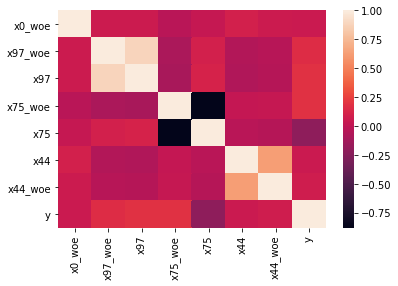

In [119]:
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns)

In [28]:
# create a sample for bar chart 
x_plot=df_train_v2.groupby('x44_bin')['y'].mean()
x_plot=x_plot.reset_index()
x_plot=x_plot.reset_index()
x_plot.head()

,index,x44_bin,y
0,0,"(-423.121, -55.613]",0.160192
1,1,"(-55.613, 16.903]",0.237156
2,2,"(16.903, 314.771]",0.213455


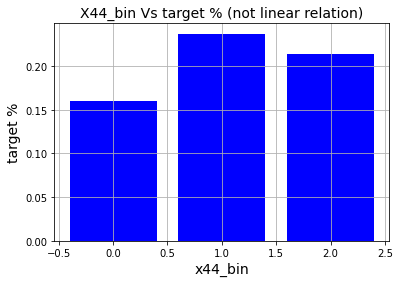

In [29]:
plt.bar(x_plot['index'], x_plot['y'], color='blue')
plt.title('X44_bin Vs target % (not linear relation)', fontsize=14)
plt.xlabel('x44_bin', fontsize=14)
plt.ylabel('target %', fontsize=14)
plt.grid(True)
plt.show()

In [115]:
# create a sample for bar chart 
x_plot=df_train_v2.groupby('x75_bin')['y'].mean()
x_plot=x_plot.reset_index()
x_plot=x_plot.reset_index()
x_plot.head()

,index,x75_bin,y
0,0,"(-146.96800000000002, -9.417]",0.304335
1,1,"(-9.417, 20.685]",0.183680
2,2,"(20.685, 144.548]",0.122778


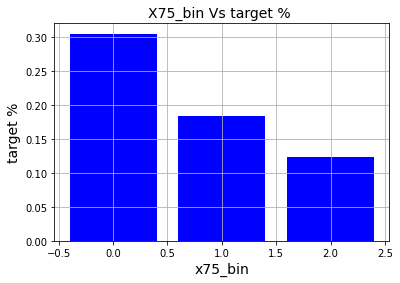

In [116]:
plt.bar(x_plot['index'], x_plot['y'], color='blue')
plt.title('X75_bin Vs target % ', fontsize=14)
plt.xlabel('x75_bin', fontsize=14)
plt.ylabel('target %', fontsize=14)
plt.grid(True)
plt.show()

## Compute bin and woe features and add them into test data for prediction

In [30]:
X_tst=df_test

In [31]:
output_woe_bins=clf_woe.woe_bins  # test data transformation
output_mono_bins=clf_woe.mono_custom_binning # future transformaion
clf_woe=WOE(woe_bins=output_woe_bins,mono_custom_binning=output_mono_bins) # output_bins was created on training data
out_woe_X_tst=clf_woe.transform(X_tst)

clf_bin=MonotonicBinning(custom_binning=output_bins)
out_bin_X_tst=clf_bin.transform(X_tst)

In [32]:
out_bin_X_tst=out_bin_X_tst.add_suffix('_bin')
out_woe_X_tst=out_woe_X_tst.add_suffix('_woe')

In [33]:
# ensure the woe fields are numeric
cols = out_woe_X_tst.columns
out_woe_X_tst[cols] = out_woe_X_tst[cols].apply(pd.to_numeric, errors='coerce')
out_woe_X_tst=out_woe_X_tst.fillna(0)

In [36]:
df_test_v2 = pd.concat([df_test, out_woe_X_tst,out_bin_X_tst], axis=1)

In [38]:
df_test_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 300 entries, x0 to x45_cat_bin
dtypes: category(95), float64(195), object(10)
memory usage: 16.6+ MB


In [39]:
df_test_v2.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x42,x43,x44,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x41_float,x45_cat,x0_woe,x1_woe,x2_woe,x3_woe,x4_woe,x5_woe,x6_woe,x7_woe,x8_woe,x9_woe,x10_woe,x11_woe,x12_woe,x13_woe,x14_woe,x15_woe,x16_woe,x17_woe,x18_woe,x19_woe,x20_woe,x21_woe,x22_woe,x23_woe,x24_woe,x25_woe,x26_woe,x27_woe,x28_woe,x29_woe,x30_woe,x31_woe,x32_woe,x33_woe,x34_woe,x35_woe,x36_woe,x37_woe,x38_woe,x39_woe,x40_woe,x42_woe,x43_woe,x44_woe,x46_woe,x47_woe,x48_woe,x49_woe,x50_woe,x51_woe,x52_woe,x53_woe,x54_woe,x55_woe,x56_woe,x57_woe,x58_woe,x59_woe,x60_woe,x61_woe,x62_woe,x63_woe,x64_woe,x65_woe,x66_woe,x67_woe,x68_woe,x69_woe,x70_woe,x71_woe,x72_woe,x73_woe,x74_woe,x75_woe,x76_woe,x77_woe,x78_woe,x79_woe,x80_woe,x81_woe,x82_woe,x83_woe,x84_woe,x85_woe,x86_woe,x87_woe,x88_woe,x89_woe,x90_woe,x91_woe,x92_woe,x93_woe,x94_woe,x95_woe,x96_woe,x97_woe,x98_woe,x99_woe,x41_float_woe,x45_cat_woe,x0_bin,x1_bin,x2_bin,x3_bin,x4_bin,x5_bin,x6_bin,x7_bin,x8_bin,x9_bin,x10_bin,x11_bin,x12_bin,x13_bin,x14_bin,x15_bin,x16_bin,x17_bin,x18_bin,x19_bin,x20_bin,x21_bin,x22_bin,x23_bin,x24_bin,x25_bin,x26_bin,x27_bin,x28_bin,x29_bin,x30_bin,x31_bin,x32_bin,x33_bin,x34_bin,x35_bin,x36_bin,x37_bin,x38_bin,x39_bin,x40_bin,x42_bin,x43_bin,x44_bin,x46_bin,x47_bin,x48_bin,x49_bin,x50_bin,x51_bin,x52_bin,x53_bin,x54_bin,x55_bin,x56_bin,x57_bin,x58_bin,x59_bin,x60_bin,x61_bin,x62_bin,x63_bin,x64_bin,x65_bin,x66_bin,x67_bin,x68_bin,x69_bin,x70_bin,x71_bin,x72_bin,x73_bin,x74_bin,x75_bin,x76_bin,x77_bin,x78_bin,x79_bin,x80_bin,x81_bin,x82_bin,x83_bin,x84_bin,x85_bin,x86_bin,x87_bin,x88_bin,x89_bin,x90_bin,x91_bin,x92_bin,x93_bin,x94_bin,x95_bin,x96_bin,x97_bin,x98_bin,x99_bin,x41_float_bin,x45_cat_bin
0,6.625366,54.479467,15.285444,-0.794648,22.498346,-29.212209,1.435134,-4.551934,5.930404,-3.319388,72.390215,2.308400,7.903161,-4.029171,-0.491208,3.630744,-10.042042,-3.468681,-15.963874,-2.566763,2.975753,5.103209,-59.107388,-2.703526,-3.279089,-0.880084,-1.714612,13.111325,1.390706,-0.367491,-4.761445,-4.871076,-3.231756,6.153179,volkswagon,wednesday,-0.664187,-32.086998,-10.126111,3.800893,-8.776231,-18.811905,18.732145,-37.212324,0.323935,-0.174701,-2.029879,-6.599810,-21.992606,21.511259,-1.225105,39.746127,6.689695,-0.260532,18.759685,37.577077,5.093232,6.451245,-8.224452,2.310597,1.547954,-13.041408,-1.808780,-0.515673,50.510892,8.556449,Aug,-54.787711,44.269118,-14.569015,2.317579,36.138153,-7.888544,80.851384,5.663648,59.069800,5.743085,12.317578,-26.306317,0.956391,5.060936,3.358217,-2.872924,10.211297,-0.006703,-11.064872,-2.393787,2.487149,-18.919238,1.774657,2.216406,america,0.987554,34.396477,-55.883515,13.739194,2.824056,1.141799,2475.46,-0.01%,-0.002129,0.291067,0.035883,0.262730,-0.031563,0.193851,-0.001203,-0.023663,-0.068264,-0.052051,-0.243425,-0.006766,-0.044339,-0.018979,0.013545,0.003420,-0.006860,0.014368,-0.011045,0.040406,-0.017015,-0.044814,0.240985,-0.016080,-0.010114,-0.000277,-0.015241,0.056592,0.002497,0.034429,0.016660,0.003787,-0.013375,0.230527,0.008263,0.124870,-0.000740,0.472614,0.005632,-0.010486,-0.051957,0.039408,-0.016080,0.195608,-0.014213,0.013545,0.024884,-0.000834,0.245838,0.208417,-0.023663,-0.004910,0.019957,-0.003982,-0.212996,0.061955,0.456666,-0.008625,-0.01058,-0.036756,-0.008160,-0.252711,-0.012349,-0.032035,-0.265700,-0.006766,-0.066473,-0.213615,-0.265153,0.048968,0.197680,0.236219,-0.053390,-0.602437,-0.00491,-0.002129,0.275606,0.241894,-0.043958,0.00803,-0.015614,0.218275,-0.001297,0.233782,-0.001203,0.024884,-0.000834,0.005265,-0.006302,-0.033922,-0.031092,0.081786,0.029531,-0.039596,0.216127,0.479982,-0.010020,0.251584,-0.518762,0.130741,"(-3.498, 10.388]","(8.023, 153.469]","(-14.617, 18.18]","(-6.27800000

In [40]:
# Save copies of data
df_train_v2.to_csv('/disk/exercise/df_train_clean_v2.csv',index=False)
df_test_v2.to_csv('/disk/exercise/df_test_clean_v2.csv',index=False)

### Variable list used for identify final variables which are selected from variable importance ranking in RF

In [ ]:
feature_lst=["x0",
"x1",
"x10",
"x12",
"x18",
"x19",
"x2",
"x21",
"x22",
"x25",
"x27",
"x3",
"x33",
"x37",
"x4",
"x40",
"x41_float",
"x43",
"x44",
"x47",
"x49",
"x5",
"x50",
"x51",
"x53",
"x56",
"x57",
"x58",
"x63",
"x66",
"x69",
"x70",
"x71",
"x72",
"x73",
"x74",
"x75",
"x77",
"x78",
"x79",
"x8",
"x80",
"x83",
"x85",
"x90",
"x95",
"x96",
"x97",
"x99",
"x0_woe",
"x1_woe",
"x10_woe",
"x12_woe",
"x18_woe",
"x19_woe",
"x2_woe",
"x21_woe",
"x22_woe",
"x25_woe",
"x27_woe",
"x3_woe",
"x33_woe",
"x35_woe",
"x37_woe",
"x4_woe",
"x40_woe",
"x41_float_woe",
"x43_woe",
"x44_woe",
"x45_cat_woe",
"x47_woe",
"x49_woe",
"x5_woe",
"x50_woe",
"x51_woe",
"x53_woe",
"x56_woe",
"x57_woe",
"x58_woe",
"x63_woe",
"x66_woe",
"x69_woe",
"x70_woe",
"x71_woe",
"x72_woe",
"x73_woe",
"x74_woe",
"x75_woe",
"x77_woe",
"x78_woe",
"x79_woe",
"x8_woe",
"x80_woe",
"x83_woe",
"x85_woe",
"x90_woe",
"x95_woe",
"x96_woe",
"x97_woe",
"x99_woe"]

In [ ]:
lst_bin=["x0_bin",
"x1_bin",
"x2_bin",
"x3_bin",
"x4_bin",
"x5_bin",
"x6_bin",
"x7_bin",
"x8_bin",
"x9_bin",
"x10_bin",
"x11_bin",
"x12_bin",
"x13_bin",
"x14_bin",
"x15_bin",
"x16_bin",
"x17_bin",
"x18_bin",
"x19_bin",
"x20_bin",
"x21_bin",
"x22_bin",
"x23_bin",
"x24_bin",
"x25_bin",
"x26_bin",
"x27_bin",
"x28_bin",
"x29_bin",
"x30_bin",
"x31_bin",
"x32_bin",
"x33_bin",
"x34_bin",
"x35_bin",
"x36_bin",
"x37_bin",
"x38_bin",
"x39_bin",
"x40_bin",
"x42_bin",
"x43_bin",
"x44_bin",
"x46_bin",
"x47_bin",
"x48_bin",
"x49_bin",
"x50_bin",
"x51_bin",
"x52_bin",
"x53_bin",
"x54_bin",
"x55_bin",
"x56_bin",
"x57_bin",
"x58_bin",
"x59_bin",
"x60_bin",
"x61_bin",
"x62_bin",
"x63_bin",
"x64_bin",
"x65_bin",
"x66_bin",
"x67_bin",
"x68_bin",
"x69_bin",
"x70_bin",
"x71_bin",
"x72_bin",
"x73_bin",
"x74_bin",
"x75_bin",
"x76_bin",
"x77_bin",
"x78_bin",
"x79_bin",
"x80_bin",
"x81_bin",
"x82_bin",
"x83_bin",
"x84_bin",
"x85_bin",
"x86_bin",
"x87_bin",
"x88_bin",
"x89_bin",
"x90_bin",
"x91_bin",
"x92_bin",
"x93_bin",
"x94_bin",
"x95_bin",
"x96_bin",
"x97_bin",
"x98_bin",
"x99_bin",
"x41_float_bin",
"x45_cat_bin"]

In [ ]:
lst_dummy=[
    "x75_bin_(-146.96800000000002, -9.417]",
"x97_bin_(5.418, 76.12]",
"x37_bin_(18.163, 126.924]",
"x41_float_bin_(-4496.461, -427.17]",
"x37_bin_(-127.653, -9.029]",
"x58_bin_(1.872, 22.421]",
"x75_bin_(20.685, 144.548]",
"x58_bin_(-31.397000000000002, -3.636]",
"x99_bin_(-4.378, -0.441]",
"x99_bin_(0.527, 4.49]",
"x21_bin_(-145.362, -8.663]",
"x51_bin_(-167.273, -22.211]",
"x66_bin_(-177.82500000000002, -19.042]",
"x40_bin_(16.254, 159.814]",
"x97_bin_(-73.91000000000001, -10.571]",
"x1_bin_(8.023, 153.469]",
"x50_bin_(-78.22200000000001, -4.706]",
"x70_bin_(-135.731, -8.81]",
"x56_bin_(-128.053, -14.085]",
"x63_bin_(3.269, 55.602]",
"x53_bin_(-90.81200000000001, -10.548]",
"x53_bin_(10.726, 98.202]",
"x96_bin_(9.586, 92.927]",
"x78_bin_(0.982, 16.759]",
"x41_float_bin_(432.19, 4062.63]",
"x83_bin_(2.343, 19.617]",
"x12_bin_(3.23, 70.297]",
"x3_bin_(-6.2780000000000005, -0.712]",
"x22_bin_(-162.27700000000002, -18.253]",
"x79_bin_(10.721, 84.288]",
"x44_bin_(-423.121, -55.613]",
"x96_bin_(-108.476, -10.862]",
"x1_bin_(-157.342, -23.872]",
"x66_bin_(14.303, 204.417]",
"x10_bin_(-170.57, -9.701]",
"x83_bin_(-22.232000000000003, -1.916]",
"x72_bin_(-34.78, -4.881]",
"x85_bin_(4.152, 70.386]",
"x10_bin_(25.072, 174.685]",
"x50_bin_(12.362, 90.662]",
"x73_bin_(6.912, 92.753]",
"x12_bin_(-78.367, -12.084]",
"x72_bin_(1.855, 32.581]",
"x51_bin_(9.731, 153.279]",
"x63_bin_(-65.171, -8.682]",
"x5_bin_(6.133, 63.424]",
"x73_bin_(-121.801, -16.448]",
"x2_bin_(18.18, 154.051]",
"x2_bin_(-163.341, -14.617]",
"x19_bin_(-84.21300000000001, -9.118]",
"x33_bin_(0.804, 14.989]",
"x40_bin_(-141.839, -13.664]",
"x8_bin_(2.729, 66.937]",
"x57_bin_(-161.357, -15.651]",
"x21_bin_(21.704, 156.785]",
"x71_bin_(15.902, 130.349]",
"x5_bin_(-62.809999999999995, -7.34]",
"x44_bin_(16.903, 314.771]",
"x79_bin_(-90.339, -8.337]",
"x69_bin_(20.878, 308.325]",
"x8_bin_(-53.736999999999995, -8.545]",
"x35_bin_thurday",
"x43_bin_(-61.803999999999995, -6.482]",
"x22_bin_(13.729, 161.447]",
"x3_bin_(0.571, 5.838]",
"x19_bin_(9.115, 82.897]",
"x4_bin_(-61.632999999999996, -6.877]",
"x4_bin_(7.114, 65.95]",
"x0_bin_(-60.114999999999995, -3.498]",
"x78_bin_(-16.978, -2.415]",
"x27_bin_(26.801, 172.001]",
"x57_bin_(14.49, 147.697]",
"x74_bin_(11.783, 125.996]",
"x43_bin_(6.582, 71.281]",
"x25_bin_(1.721, 18.599]",
"x95_bin_(-125.066, -11.66]",
"x33_bin_(-16.232000000000003, -2.175]",
"x27_bin_(-143.038, -7.811]",
"x70_bin_(23.151, 159.477]",
"x56_bin_(11.683, 132.981]",
"x35_bin_wednesday",
"x20_bin_(-72.674, -3.888]",
"x47_bin_(1.903, 21.374]",
"x47_bin_(-18.657, -1.987]",
"x95_bin_(11.926, 112.391]",
"x71_bin_(-139.779, -14.577]",
"x25_bin_(-15.66, -1.725]",
"x49_bin_(5.627, 55.721]",
"x42_bin_(-109.446, -9.801]",
"x77_bin_(14.321, 177.43]",
"x49_bin_(-54.269999999999996, -5.34]",
"x61_bin_(6.53, 68.764]",
"x61_bin_(-62.785, -6.299]",
"x0_bin_(10.388, 75.312]",
"x77_bin_(-159.804, -15.476]",
"x42_bin_(8.769, 101.316]",
"x85_bin_(-79.754, -11.543]",
"x80_bin_(-77.052, -8.357]",
"x20_bin_(10.083, 71.673]",
"x18_bin_(-103.96000000000001, -5.162]",
"x80_bin_(7.993, 91.071]",
"x90_bin_(-422.71299999999997, -49.648]",
"x90_bin_(33.786, 378.752]",
"x44_bin_(-55.613, 16.903]",
"x18_bin_(18.721, 107.938]",
"x37_bin_(-9.029, 18.163]",
"x69_bin_(-297.613, -35.821]",
"x74_bin_(-108.745, -11.564]",
"x75_bin_(-9.417, 20.685]",
"x45_cat_bin_-0.02%",
"x97_bin_(-10.571, 5.418]",
"x45_cat_bin_-0.01%",
"x58_bin_(-3.636, 1.872]",
"x99_bin_(-0.441, 0.527]",
"x51_bin_(-22.211, 9.731]",
"x45_cat_bin_0.01%",
"x53_bin_(-10.548, 10.726]",
"x96_bin_(-10.862, 9.586]",
"x72_bin_(-4.881, 1.855]",
"x77_bin_(-15.476, 14.321]",
"x73_bin_(-16.448, 6.912]",
"x5_bin_(-7.34, 6.133]",
"x71_bin_(-14.577, 15.902]",
"x95_bin_(-11.66, 11.926]",
"x8_bin_(-8.545, 2.729]",
"x4_bin_(-6.877, 7.114]",
"x80_bin_(-8.357, 7.993]",
"x66_bin_(-19.042, 14.303]",
"x41_float_bin_(-427.17, 432.19]",
"x21_bin_(-8.663, 21.704]",
"x19_bin_(-9.118, 9.115]",
"x83_bin_(-1.916, 2.343]",
"x60_bin_(-24.804000000000002, -2.404]",
"x2_bin_(-14.617, 18.18]",
"x15_bin_(3.794, 42.616]",
"x12_bin_(-12.084, 3.23]",
"x3_bin_(-0.712, 0.571]",
"x56_bin_(-14.085, 11.683]",
"x55_bin_(-1.495, 1.569]",
"x50_bin_(-4.706, 12.362]",
"x68_bin_Jun",
"x27_bin_(-7.811, 26.801]",
"x69_bin_(-35.821, 20.878]",
"x25_bin_(-1.725, 1.721]",
"x38_bin_(3.196, 29.333]",
"x24_bin_(-14.716, -1.606]",
"x14_bin_(-1.341, 1.329]",
"x65_bin_(0.529, 5.449]",
"x63_bin_(-8.682, 3.269]",
"x9_bin_(-11.498, -1.305]",
"x59_bin_(-2.622, 2.593]",
"x9_bin_(-1.305, 1.225]",
"x52_bin_(0.423, 3.971]",
"x61_bin_(-6.299, 6.53]",
"x30_bin_(-1.436, 1.392]",
"x78_bin_(-2.415, 0.982]",
"x11_bin_(1.93, 17.034]",
"x70_bin_(-8.81, 23.151]",
"x48_bin_(-14.62, -1.553]",
"x22_bin_(-18.253, 13.729]",
"x43_bin_(-6.482, 6.582]",
"x62_bin_(-3.221, 3.161]",
"x40_bin_(-13.664, 16.254]",
"x28_bin_(1.229, 13.38]",
"x1_bin_(-23.872, 8.023]",
"x98_bin_(3.657, 34.17]",
"x55_bin_(-15.929, -1.495]",
"x94_bin_(-9.397, -0.956]",
"x11_bin_(-1.892, 1.93]",
"x65_bin_(-0.552, 0.529]",
"x32_bin_(-0.693, 0.699]",
"x24_bin_(-1.606, 1.638]",
"x86_bin_(-0.25, 0.251]",
"x10_bin_(-9.701, 25.072]",
"x14_bin_(-12.754, -1.341]",
"x30_bin_(1.392, 13.026]",
"x57_bin_(-15.651, 14.49]",
"x64_bin_(-30.072000000000003, -3.439]",
"x54_bin_(2.147, 19.731]",
"x33_bin_(-2.175, 0.804]",
"x94_bin_(0.935, 9.137]",
"x29_bin_(0.371, 3.713]",
"x60_bin_(-2.404, 2.407]",
"x31_bin_(-23.832, -2.437]",
"x89_bin_(-1.742, 1.765]",
"x68_bin_Aug",
"x16_bin_(-1.791, 1.727]",
"x74_bin_(-11.564, 11.783]",
"x81_bin_(4.229, 43.666]",
"x39_bin_(-4.138, 4.238]",
"x17_bin_(-25.739, -2.879]",
"x84_bin_(-22.499000000000002, -2.244]",
"x29_bin_(-3.582, -0.367]",
"x94_bin_(-0.956, 0.935]",
"x91_bin_(-1.139, 1.122]",
"x6_bin_(-35.062, -3.849]",
"x28_bin_(-1.289, 1.229]",
"x36_bin_(-0.713, 0.72]",
"x64_bin_(-3.439, 3.409]",
"x65_bin_(-5.445, -0.552]"
]
lst_other=["x75",
"x97",
"x37",
"x58",
"x41_float",
"x53",
"x66",
"x99",
"x1",
"x63",
"x12",
"x21",
"x83",
"x40",
"x50",
"x51",
"x56",
"x3",
"x44",
"x70",
"x96",
"x78",
"x72",
"x75_woe",
"x10",
"x5",
"x43",
"x22",
"x8",
"x4",
"x73",
"x85",
"x57",
"x79",
"x19",
"x2",
"x33",
"x69",
"x47",
"x27",
"x49",
"x71",
"x37_woe",
"x95",
"x25",
"x74",
"x0",
"x77",
"x80",
"x18",
"x90",
"x58_woe",
"x97_woe",
"x99_woe",
"x41_float_woe",
"x45_cat_woe",
"x66_woe",
"x21_woe",
"x50_woe",
"x1_woe",
"x40_woe",
"x53_woe",
"x83_woe",
"x51_woe",
"x56_woe",
"x63_woe",
"x12_woe",
"x5_woe",
"x96_woe",
"x35_woe",
"x22_woe",
"x10_woe",
"x3_woe",
"x70_woe",
"x44_woe",
"x73_woe",
"x78_woe",
"x72_woe",
"x79_woe",
"x2_woe",
"x43_woe",
"x33_woe",
"x57_woe",
"x25_woe",
"x8_woe",
"x85_woe",
"x4_woe",
"x0_woe",
"x19_woe",
"x95_woe",
"x69_woe",
"x27_woe",
"x47_woe",
"x74_woe",
"x71_woe",
"x49_woe",
"x77_woe",
"x80_woe",
"x18_woe",
"x90_woe"]

<a class="anchor" id="dummy"></a>
### Create Dummy Variables and Select variable list based on rank of variable importance obtained from RandomForest

In [ ]:
train_bin=df_train_v2[lst_bin]
train_features=pd.get_dummies(train_bin)
train_features_dummy=train_features[lst_dummy]
train_feature_other=df_train_v2[lst_other]

train_features=pd.concat([train_features_dummy,train_feature_other],axis=1)
train_label=df_train_v2['y']

train_features.head()

test_bin=df_test_v2[lst_bin]
test_features=pd.get_dummies(test_bin)
test_features_dummy=test_features[lst_dummy]
test_feature_other=df_test_v2[lst_other]

test_features=pd.concat([test_features_dummy,test_feature_other],axis=1)
test_features.head()

### RandomForest code for variable importance rank <a class="anchor" id="rf_imp"></a>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(train_features,train_label)

preds = clf.predict(train_features)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,train_label)
#print(accuracy)

from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=train_features.columns)
VI = VI.reset_index()
VI.sort_values(['RF'],ascending=0)

print(VI.sort_values(['RF'],ascending=0))

## Model 1:  Gradient Boosting (GBM)  <a class="anchor" id="Model1"></a>

In [152]:
import sklearn
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [105]:
print(GradientBoostingClassifier())
print(GradientBoostingRegressor())

GradientBoostingClassifier()
GradientBoostingRegressor()


### Tune model hyper-parameters: learning rate, number of trees, depth of tree to find optimal hyper parameters <a class="anchor" id="tune"></a>

In [201]:
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators":[5,10,20,30,50,70],
    "max_depth":[1,2,3,5],
    "learning_rate":[0.01,0.1,0.2,0.5]
}

In [163]:
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators":[50,80,100,150],
    "max_depth":[1,3,4],
    "learning_rate":[0.15,0.2, 0.3,0.5]
}

,"x75_bin_(-146.96800000000002, -9.417]","x97_bin_(5.418, 76.12]","x37_bin_(18.163, 126.924]","x41_float_bin_(-4496.461, -427.17]","x37_bin_(-127.653, -9.029]","x58_bin_(1.872, 22.421]","x75_bin_(20.685, 144.548]","x58_bin_(-31.397000000000002, -3.636]","x99_bin_(-4.378, -0.441]","x99_bin_(0.527, 4.49]","x21_bin_(-145.362, -8.663]","x51_bin_(-167.273, -22.211]","x66_bin_(-177.82500000000002, -19.042]","x40_bin_(16.254, 159.814]","x97_bin_(-73.91000000000001, -10.571]","x1_bin_(8.023, 153.469]","x50_bin_(-78.22200000000001, -4.706]","x70_bin_(-135.731, -8.81]","x56_bin_(-128.053, -14.085]","x63_bin_(3.269, 55.602]","x53_bin_(-90.81200000000001, -10.548]","x53_bin_(10.726, 98.202]","x96_bin_(9.586, 92.927]","x78_bin_(0.982, 16.759]","x41_float_bin_(432.19, 4062.63]","x83_bin_(2.343, 19.617]","x12_bin_(3.23, 70.297]","x3_bin_(-6.2780000000000005, -0.712]","x22_bin_(-162.27700000000002, -18.253]","x79_bin_(10.721, 84.288]","x44_bin_(-423.121, -55.613]","x96_bin_(-108.476, -10.862]","x1_bin_(-157.342, -23.872]","x66_bin_(14.303, 204.417]","x10_bin_(-170.57, -9.701]","x83_bin_(-22.232000000000003, -1.916]","x72_bin_(-34.78, -4.881]","x85_bin_(4.152, 70.386]","x10_bin_(25.072, 174.685]","x50_bin_(12.362, 90.662]","x73_bin_(6.912, 92.753]","x12_bin_(-78.367, -12.084]","x72_bin_(1.855, 32.581]","x51_bin_(9.731, 153.279]","x63_bin_(-65.171, -8.682]","x5_bin_(6.133, 63.424]","x73_bin_(-121.801, -16.448]","x2_bin_(18.18, 154.051]","x2_bin_(-163.341, -14.617]","x19_bin_(-84.21300000000001, -9.118]","x33_bin_(0.804, 14.989]","x40_bin_(-141.839, -13.664]","x8_bin_(2.729, 66.937]","x57_bin_(-161.357, -15.651]","x21_bin_(21.704, 156.785]","x71_bin_(15.902, 130.349]","x5_bin_(-62.809999999999995, -7.34]","x44_bin_(16.903, 314.771]","x79_bin_(-90.339, -8.337]","x69_bin_(20.878, 308.325]","x8_bin_(-53.736999999999995, -8.545]",x35_bin_thurday,"x43_bin_(-61.803999999999995, -6.482]","x22_bin_(13.729, 161.447]","x3_bin_(0.571, 5.838]","x19_bin_(9.115, 82.897]","x4_bin_(-61.632999999999996, -6.877]","x4_bin_(7.114, 65.95]","x0_bin_(-60.114999999999995, -3.498]","x78_bin_(-16.978, -2.415]","x27_bin_(26.801, 172.001]","x57_bin_(14.49, 147.697]","x74_bin_(11.783, 125.996]","x43_bin_(6.582, 71.281]","x25_bin_(1.721, 18.599]","x95_bin_(-125.066, -11.66]","x33_bin_(-16.232000000000003, -2.175]","x27_bin_(-143.038, -7.811]","x70_bin_(23.151, 159.477]","x56_bin_(11.683, 132.981]",x35_bin_wednesday,"x20_bin_(-72.674, -3.888]","x47_bin_(1.903, 21.374]","x47_bin_(-18.657, -1.987]","x95_bin_(11.926, 112.391]","x71_bin_(-139.779, -14.577]","x25_bin_(-15.66, -1.725]","x49_bin_(5.627, 55.721]","x42_bin_(-109.446, -9.801]","x77_bin_(14.321, 177.43]","x49_bin_(-54.269999999999996, -5.34]","x61_bin_(6.53, 68.764]","x61_bin_(-62.785, -6.299]","x0_bin_(10.388, 75.312]","x77_bin_(-159.804, -15.476]","x42_bin_(8.769, 101.316]","x85_bin_(-79.754, -11.543]","x80_bin_(-77.052, -8.357]","x20_bin_(10.083, 71.673]","x18_bin_(-103.96000000000001, -5.162]","x80_bin_(7.993, 91.071]","x90_bin_(-422.71299999999997, -49.648]","x90_bin_(33.786, 378.752]","x44_bin_(-55.613, 16.903]","x18_bin_(18.721, 107.938]","x37_bin_(-9.029, 18.163]","x69_bin_(-297.613, -35.821]","x74_bin_(-108.745, -11.564]","x75_bin_(-9.417, 20.685]",x45_cat_bin_-0.02%,"x97_bin_(-10.571, 5.418]",x45_cat_bin_-0.01%,"x58_bin_(-3.636, 1.872]","x99_bin_(-0.441, 0.527]","x51_bin_(-22.211, 9.731]",x45_cat_bin_0.01%,"x53_bin_(-10.548, 10.726]","x96_bin_(-10.862, 9.586]","x72_bin_(-4.881, 1.855]","x77_bin_(-15.476, 14.321]","x73_bin_(-16.448, 6.912]","x5_bin_(-7.34, 6.133]","x71_bin_(-14.577, 15.902]","x95_bin_(-11.66, 11.926]","x8_bin_(-8.545, 2.729]","x4_bin_(-6.877, 7.114]","x80_bin_(-8.357, 7.993]","x66_bin_(-19.042, 14.303]","x41_float_bin_(-427.17, 432.19]","x21_bin_(-8.663, 21.704]","x19_bin_(-9.118, 9.115]","x83_bin_(-1.916, 2.343]","x60_bin_(-24.804000000000002, -2.404]","x2_bin_(-14.617, 18.18]","x15_bin_(3.794, 42.616]","x12_bin_(-12.084, 3.23]","x3_bin_(-0.712, 0.571]","x56_bin_(-14.085, 11.683]","x55_bin_(-1

 <a class="anchor" id="tune_run"></a>
### Apply cross validation to find the optimal set of hyper parmeters

In [164]:
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(gbc,parameters,cv=4)
cv.fit(train_features,train_label.values.ravel())

GridSearchCV(cv=4, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.15, 0.2, 0.3, 0.5],
                         'max_depth': [1, 3, 4],
                         'n_estimators': [50, 80, 100, 150]})

In [165]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [166]:
display(cv)

Best parameters are: {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 150}


0.805 + or -0.001 for the {'learning_rate': 0.15, 'max_depth': 1, 'n_estimators': 50}
0.817 + or -0.0 for the {'learning_rate': 0.15, 'max_depth': 1, 'n_estimators': 80}
0.824 + or -0.002 for the {'learning_rate': 0.15, 'max_depth': 1, 'n_estimators': 100}
0.838 + or -0.003 for the {'learning_rate': 0.15, 'max_depth': 1, 'n_estimators': 150}
0.891 + or -0.003 for the {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 50}
0.911 + or -0.004 for the {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 80}
0.919 + or -0.003 for the {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 100}
0.933 + or -0.003 for the {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 150}
0.915 + or -0.002 for the {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 50}
0.933 + or -0.002 for the {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 80}
0.94 + or -0.002 for the {'learning_rate': 0.15, 'max_d

In [157]:
display(cv)

Best parameters are: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 80}


0.796 + or -0.0 for the {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 10}
0.796 + or -0.0 for the {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 50}
0.797 + or -0.0 for the {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 80}
0.796 + or -0.0 for the {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 10}
0.83 + or -0.0 for the {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
0.856 + or -0.002 for the {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 80}
0.796 + or -0.0 for the {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 10}
0.799 + or -0.0 for the {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}
0.805 + or -0.001 for the {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 80}
0.798 + or -0.0 for the {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10}
0.87 + or -0.002 for the {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators':

In [50]:
model = GradientBoostingClassifier(learning_rate=0.1,max_depth=3,n_estimators=50,random_state=0)
model.fit(train_features, train_label)

GradientBoostingClassifier(n_estimators=50, random_state=0)

### Run model with Tuned Set of Hyperparameter and Compute AUC on training dataset

In [167]:
model = GradientBoostingClassifier(learning_rate=0.5,max_depth=4,n_estimators=150,random_state=0)
model.fit(train_features, train_label)

import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.array(train_label),model.predict_proba(train_features)[:,1] )
print(metrics.auc(fpr, tpr))

0.9986585516763055


In [273]:
model = GradientBoostingClassifier(learning_rate=0.3,max_depth=3,n_estimators=80,random_state=0)
model.fit(train_features, train_label)

import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.array(train_label),model.predict_proba(train_features)[:,1] )
print(metrics.auc(fpr, tpr))

0.9804158157928755


## Model 2:  Stack Models of Logistic Regression, Naive Bayes and GBM<a class="anchor" id="Model2"></a>

<a class="anchor" id="logit"></a>
### Run logistic regression and Naive Bayes models to check performance. Random split the original training with target

In [170]:
from sklearn.model_selection import train_test_split

In [179]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_label, test_size=0.33, random_state=42)

In [187]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(X_train,y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,y_train)
accuracy_test = accuracy_score(pred_test,y_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(y_train), clf.predict_proba(X_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(y_test), clf.predict_proba(X_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)


0.886455223880597 0.8818181818181818 0.9055848797171174 0.8981393662252359


/root/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Plot a cumulative gain chart (on test predict) to show the cumulative percent of target captured by cumulative score(descending) deciles <a class="anchor" id="gain_chart"></a>

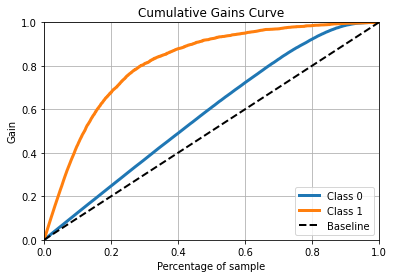

In [188]:
import matplotlib.pyplot as plt
import scikitplot as skplt
predicted_probas=clf.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

### Naive Bayes Model<a class="anchor" id="nb"></a>

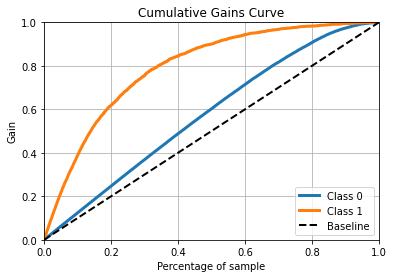

In [185]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
predicted_probas = nb.predict_proba(X_test)

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

### Cross validation AUC in Logistic Regression : AUCs are above 0.90  <a class="anchor" id="cv"></a>

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
#from sklearn.naive_bayes import GaussianNB 

crossval_scores = cross_val_score(LogisticRegression(), train_features, train_label, scoring='roc_auc', cv=5)
##crossval_scores = cross_val_score(GaussianNB(), train_features, train_label, scoring='roc_auc', cv=5)
print(crossval_scores)

/root/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/root/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[0.89581319 0.90012342 0.90754444 0.90217509 0.90708801]


/root/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Run logistic regression and Naive Bayes on full training data and get predicted probabilities<a class="anchor" id="logit"></a>

In [275]:
# predict test data with logistic regression
clf = LogisticRegression()
clf.fit(train_features,train_label)
pred_train_logit = pd.DataFrame(clf.predict_proba(train_features))
pred_train_logit.columns=['pred_lr_0','pred_lr_1']
pred_test_logit = pd.DataFrame(clf.predict_proba(test_features))
pred_test_logit.columns=['pred_lr_0','pred_lr_1']

nb = GaussianNB()
nb.fit(train_features,train_label)
pred_train_nb = pd.DataFrame(nb.predict_proba(train_features))
pred_train_nb.columns=['pred_nb0','pred_nb1']
pred_test_nb = pd.DataFrame(nb.predict_proba(test_features))
pred_test_nb.columns=['pred_nb0','pred_nb1']


/root/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Add predicted probabilities to training and test data as extra features

In [258]:
train_features_stack=pd.concat([train_features,pred_train_nb['pred_nb1'],pred_train_logit['pred_lr_1']],axis=1)
test_features_stack=pd.concat([test_features,pred_test_nb['pred_nb1'],pred_test_logit['pred_lr_1']],axis=1)

<a class="anchor" id="stack"></a>
## Run Model that stack original features and predictions (logistic and naive bayes) as additional features 

In [268]:
# Split the 40000 train data random and check model performance on validation.
X_train, X_test, y_train, y_test = train_test_split(train_features_stack, train_label, test_size=0.33, random_state=0)

In [269]:
model = GradientBoostingClassifier(learning_rate=0.5,max_depth=4,n_estimators=150,random_state=0)
model.fit(X_train, y_train)

import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_train),model.predict_proba(X_train)[:,1] )
print(metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_test),model.predict_proba(X_test)[:,1] )
print(metrics.auc(fpr, tpr))

0.9998070004055513
0.973447237900773


In [271]:
# Split the 40000 train data random and check model performance on validation.
X_train, X_test, y_train, y_test = train_test_split(train_features, train_label, test_size=0.33, random_state=0)

In [272]:
model = GradientBoostingClassifier(learning_rate=0.5,max_depth=4,n_estimators=150,random_state=0)
model.fit(X_train, y_train)

import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_train),model.predict_proba(X_train)[:,1] )
print(metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_test),model.predict_proba(X_test)[:,1] )
print(metrics.auc(fpr, tpr))

0.9999929338102805
0.976235928874229


In [261]:
# run on whole training data
model = GradientBoostingClassifier(learning_rate=0.5,max_depth=4,n_estimators=150,random_state=0)
model.fit(train_features_stack, train_label)

import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.array(train_label),model.predict_proba(train_features_stack)[:,1] )
print(metrics.auc(fpr, tpr))

0.9987522050972993


In [262]:
df_train_stack=pd.concat([train_features_stack,train_label],axis=1)
df_test_stack_pred=pd.Series(model.predict_proba(test_features_stack)[:,1])

## Save final modeling data

In [121]:
df_train_v3 = pd.concat([train_label,train_features], axis=1)

In [124]:
df_train_v3.to_csv('/disk/exercise/df_train_final.csv',index=False)

In [126]:
test_features.to_csv('/disk/exercise/df_test_final.csv',index=False)

In [136]:
pred_test=pd.Series(pred_test[:,1])

In [140]:
pred_test.to_csv('/disk/exercise/pred_logistic_test.csv',index=False)

In [161]:
pred_test_gbm=pd.Series(model.predict_proba(test_features)[:,1])
pred_test_gbm.to_csv('/disk/exercise/pred_gbm_test.csv',index=False)

In [ ]:
df_train_stack.to_csv('/disk/exercise/df_train_stack.csv', index=False)
df_test_stack_pred.to_csv('/disk/exercise/df_test_stack_pred.csv',index=False)